<a href="https://colab.research.google.com/github/Prasi21/Strep-Throat/blob/main/Fine_tune_BLIP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Methodology adapted from Younes Belkada
# https://github.com/huggingface/notebooks/blob/main/peft/Fine_tune_BLIP2_on_an_image_captioning_dataset_PEFT.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! We will show through this tutorial that it is possible to fine-tune a 3B scale model (~6GB in half-precision)

Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00


In [ ]:
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [ ]:
from datasets import load_dataset

fc_dataset = load_dataset("ybelkada/football-dataset", split="train")

README.md:   0%|          | 0.00/371 [00:00<?, ?B/s]

(…)-00000-of-00001-fc7c825a21687306.parquet:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Let's retrieve the caption of the first example:

In [ ]:
fc_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x360>,
 'text': "Benzema after Real Mardid's win against PSG"}

In [ ]:
fc_dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

And the corresponding image

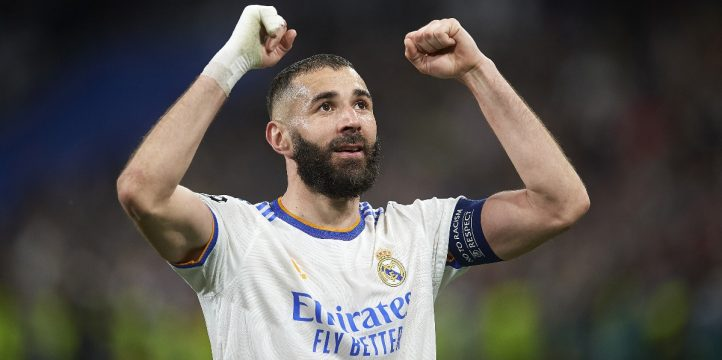

In [ ]:
fc_dataset[0]["image"]

In [ ]:
len(fc_dataset)

6

### Loading Strep Throat Dataset

In [ ]:
!ls /content/drive/MyDrive/Healthy_Connections

llm


In [ ]:
import json
from PIL import Image
import os

# Define the path to the folder with images
label_file = "/content/drive/MyDrive/Healthy_Connections/llm/datasets/throat_images_data.json"
image_folder = "/content/drive/MyDrive/STREPDB/datasets/Original"

# Sample JSON-like data
# data = [
#     {
#         "image": "1.jpeg",
#         "prompt": "Write a medical report for this image as an expert otolaryngologist. STRICTLY follow this structure. DO NOT include any other sections. Make your response as CONCISE as possible. \n~~~\n\nInspection:\nImpression:",
#         "text": "**Inspection:**\nThe image depicts the posterior oropharynx. The mucosa appears erythematous with no visible exudates, swelling, or tonsillar hypertrophy. The uvula is midline. No significant lesions or asymmetry noted.\n**Impression:**\nMild oropharyngeal erythema, possibly indicative of viral pharyngitis or non-specific irritation. No signs of bacterial infection or significant abnormality."
#     },
#     {
#         "image": "2.jpeg",
#         "prompt": "Write a medical report for this image as an expert doctor. STRICTLY follow this structure. DO NOT include any other sections. Make your response as CONCISE as possible. \n~~~\n\nInspection:\nImpression:",
#         "text": "**Inspection:**  \nThe image shows an erythematous (red) and inflamed oropharynx with diffuse hyperemia of the tonsillar pillars, uvula, and posterior pharyngeal wall. No visible exudates, pus, or white patches are noted. The tongue appears normal, and there is no significant swelling or ulceration.\n\n**Impression:**  \nAcute pharyngitis, most likely viral in origin, given the absence of tonsillar exudates. However, bacterial causes such as streptococcal pharyngitis should be considered depending on associated symptoms and clinical history."
#     },
# ]
# with open(os.path.join(image_folder,'descriptions.json'), 'r') as f:
with open(label_file, 'r') as f:
    data = json.load(f)


# Create an empty list to store the final result
final_data = []

# Loop through the data and load images and texts
for entry in data:
    image_path = os.path.join(image_folder, entry['image'])  # Combine folder path and image name

    # Open the image using PIL
    try:
        image = Image.open(image_path)
    except Exception as e:
        print(f"Error loading image {entry['image']}: {e}")
        continue  # Skip this entry if image loading fails

    # Create a dictionary with the image object and corresponding text
    final_entry = {
        'image': image,
        'text': entry['text']
    }

    # Append the final entry to the result list
    final_data.append(final_entry)

In [ ]:

dataset = final_data
# dataset = fc_dataset
dataset
len(dataset)

229










## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load pre-trained model and processor

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

original_model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", quantization_config=quantization_config)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
original_model

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
            (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post

In [ ]:
base_model = original_model

Next we define our `LoraConfig` object. We explicitly tell

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
# Increasing r and alpha increased trainable params but may improve performance
config = LoraConfig(
    r=64,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(base_model, config)
model.print_trainable_parameters()

trainable params: 20,971,520 || all params: 3,765,651,456 || trainable%: 0.5569


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
dataset[0]["text"]

'Tonsillar Exudate: Present, with white patches noted.  \nTonsillar Swelling: Present, enlarged tonsils observed.  \nUvula Deviation: NAD.  \nErythema: Present, redness noted in the oropharynx.  \nUlcers: NAD.  \nSpecial Notes: NAD.  '

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

## Train the model

In [ ]:
# end of sentence token needs to be changed to prevent generation from prematurely ending
new_eos_token_id = 13 # token id for period '.'

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Let's train the model! Run the simply the cell below for training the model

In [ ]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(4):
  print("Epoch:", epoch)
  losses = []
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    # print("Loss:", loss.item())
    losses.append(loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
  print("Loss:", sum(losses)/len(losses))
  # if epoch % 4 == 0:
  generated_output = model.generate(pixel_values=pixel_values, max_length=100, eos_token_id=new_eos_token_id)
  print(processor.batch_decode(generated_output, skip_special_tokens=True))


Epoch: 0
Loss: 0.9767495687905844
['Tonsillar Exudate: Present, with white patches observed on the tonsils.\nTonsillar Swelling: Present, tonsils appear enlarged.\nUvula Deviation: NAD.\nErythema: Present, redness noted in the throat.\nUlcers: NAD.\nSpecial Notes: NAD.\nTonsillar Swelling: NAD.\nUlcers: NAD.\nSpecial Notes: NAD.\nTonsillar Sw']
Epoch: 1
Loss: 0.32216495662540584
['Tonsillar Exudate: NAD  \nTonsillar Swelling: NAD  \nUvula Deviation: NAD  \nErythema: Present, redness noted in the throat.  \nUlcers: NAD  \nSpecial Notes: NAD  ']
Epoch: 2
Loss: 0.2570562981939935
['Tonsillar Exudate: NAD  \nTonsillar Swelling: NAD  \nUvula Deviation: NAD  \nErythema: NAD  \nUlcers: NAD  \nSpecial Notes: NAD  ']
Epoch: 3
Loss: 0.23806723062094157
['Tonsillar Exudate: NAD  \nTonsillar Swelling: NAD  \nUvula Deviation: NAD  \nErythema: NAD  \nUlcers: NAD  \nSpecial Notes: NAD  ']


## Inference

Let's check the results on our train dataset

In [ ]:
dataset.__getitem__(2)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'text': 'Tonsillar Exudate: Present, appears as a white coating on the tonsils.  \nTonsillar Swelling: Present, tonsils are enlarged.  \nUvula Deviation: NAD.  \nErythema: Present, redness noted in the throat area.  \nUlcers: NAD.  \nSpecial Notes: NAD.'}

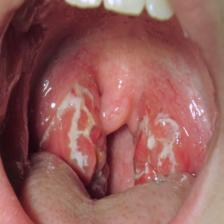

In [ ]:
# load image
example = dataset[2]
image = example["image"]
image

In [ ]:
type(original_model)

transformers.models.blip_2.modeling_blip_2.Blip2ForConditionalGeneration

In [ ]:
new_eos_token_id = 13 # token for period '.'

In [ ]:
# prepare image for the model
inputs = processor(images=image, text="", return_tensors="pt").to(device, torch.float16)

generated_ids = lora_model.generate(**inputs, max_length=100,
                                eos_token_id=new_eos_token_id)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
print(generated_caption)

['Tonsillar Exudate: Present, with white patches noted.\nTonsillar Swelling: Present, tonsils appear enlarged.\nUvula Deviation: NAD.\nErythema: Present, redness noted in the throat.\nUlcers: NAD.\nSpecial Notes: NAD.']


## Push to Hub

In [ ]:
import huggingface_hub as hub
# hub.logout()
hub.login()

In [ ]:
# Save only the LoRA adapter
model.save_pretrained("strep_blip2_lora", save_adapter=True, save_config=True)

In [ ]:
from peft import PeftModel
lora_model = PeftModel.from_pretrained(base_model, "strep_blip2_lora")

In [ ]:
from huggingface_hub import Repository

repo_id = "Prasi21/blip2-opt-2.7b-strep-throat-caption-adapters"

# Push the fine-tuned model to the Hugging Face Hub
model.push_to_hub(repo_id)

# Push the processor to the Hugging Face Hub. Processor hasn't been changed.
# processor.push_to_hub(repo_id)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Prasi21/blip2-opt-2.7b-strep-throat-caption-adapters/commit/66ffd789bfb7828d1c0e9b43a3bca6f7371a2327', commit_message='Upload model', commit_description='', oid='66ffd789bfb7828d1c0e9b43a3bca6f7371a2327', pr_url=None, pr_revision=None, pr_num=None)

## Load from the Hub

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model, PeftModel

# Load the processor
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

# Load the base model from the original repository
base_model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",
    device_map="auto",
    quantization_config=quantization_config
)

repo_id = "Prasi21/blip2-opt-2.7b-strep-throat-caption-adapters"

# Load the fine-tuned LoRA adapters from the Hugging Face Hub
lora_model = PeftModel.from_pretrained(base_model, repo_id)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Test model on validation dataset

In [ ]:
# Load Validation Images
from collections import Counter
import numpy as np


root="/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/"
# load the images in this folder into a list with Pillow
from PIL import Image
import os
import matplotlib.pyplot as plt

val_imgs = []
# for entry in data:
for filename in os.listdir("/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0"):
    # image_path = os.path.join(image_folder, entry['image'])  # Combine folder path and image name

    # Open the image using PIL
    try:
        image = Image.open(root+filename)
        val_imgs.append(image)
    except Exception as e:
        print(f"Error loading image {root+filename}: {e}")
        continue  # Skip this entry if image loading fails


Tonsillar Exudate: Present, with white patches visible on the tonsils.  
Tonsillar Swelling: Present, tonsils appear enlarged.  
Uvula Deviation: NAD.  
Erythema: Present, redness noted in the throat.  
Ulcers: NAD.  
Special Notes: NAD.  


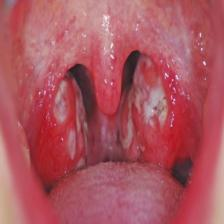

Tonsillar Exudate: Present, with white patches visible on the tonsils.  
Tonsillar Swelling: Present, tonsils appear enlarged.  
Uvula Deviation: NAD.  
Erythema: Present, redness noted in the throat area.  
Ulcers: NAD.  
Special Notes: NAD.  


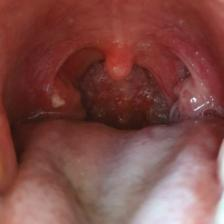

Tonsillar Exudate: Present, with white patches visible on the tonsils.  
Tonsillar Swelling: Present, tonsils appear enlarged.  
Uvula Deviation: NAD.  
Erythema: Present, redness noted in the throat.  
Ulcers: NAD.  
Special Notes: NAD.  


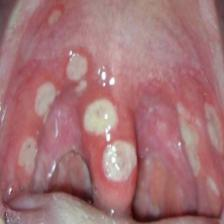

Tonsillar Exudate: Present, with white patches visible on the tonsils.  
Tonsillar Swelling: Present, tonsils appear enlarged.  
Uvula Deviation: NAD.  
Erythema: Present, redness noted in the throat.  
Ulcers: NAD.  
Special Notes: NAD.  


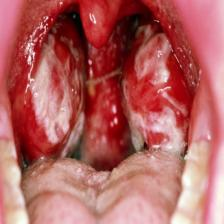

Tonsillar Exudate: Present, with white patches on the tonsils.  
Tonsillar Swelling: Present, tonsils appear enlarged.  
Uvula Deviation: NAD.  
Erythema: Present, redness noted in the throat.  
Ulcers: NAD.  
Special Notes: NAD.  


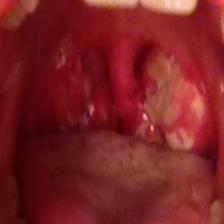

Tonsillar Exudate: NAD  
Tonsillar Swelling: NAD  
Uvula Deviation: NAD  
Erythema: Present, redness noted in the throat.  
Ulcers: NAD  
Special Notes: NAD  


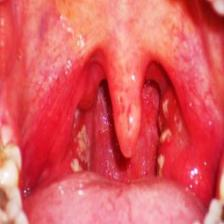

In [ ]:
for i, image in enumerate(val_imgs):
  if(i>5): break
  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values
  generated_ids = model.generate(**inputs, max_length=100,
                                eos_token_id=new_eos_token_id)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
  print(f"{generated_caption[0]}")
  display(image)


In [ ]:
"/".join(val_imgs[0].filename.split("/")[-3:])

'Valfolder/Class1/20.jpeg'

### Save Model Outputs to JSON file

In [ ]:
import json


def model_output(image):
    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values
    generated_ids = lora_model.generate(**inputs, max_length=100,
                                  eos_token_id=new_eos_token_id)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
    out = f"{generated_caption[0]}"
    return out

# Function to parse the output and save it for each characteristic
def parse_output(output):
    parsed = {}

    parsed["Tonsillar Exudate"] = output.split("Tonsillar Exudate:")[1].split("\n")[0]
    parsed["Tonsillar Swelling"] = output.split("Tonsillar Swelling:")[1].split("\n")[0]
    parsed["Uvula Deviation"] = output.split("Uvula Deviation:")[1].split("\n")[0]
    parsed["Erythema"] = output.split("Erythema:")[1].split("\n")[0]
    parsed["Ulcers"] = output.split("Ulcers:")[1].split("\n")[0]

    # Parse special notes
    notes_section = output.split("Special Notes:")[1].split("\n")[0].strip()
    parsed["notes"] = "" if "NAD" in notes_section else notes_section

    return parsed


In [ ]:
# Create the final JSON structure
results = {}

for image in val_imgs:
    output = model_output(image)  # Run the image through the model
    filename = "/".join(image.filename.split("/")[-3:])
    results[filename] = parse_output(output)  # Parse the output and add to the results
    print(results[filename])

# Convert the results into JSON format
json_data = json.dumps(results, indent=4)

# Save to file or print
print(json_data)

# Optionally, save to a file
with open("results0.json", "w") as f:
    f.write(json_data)


# Gradio Demo

In [ ]:
!pip install gradio

In [ ]:
import torch
import gradio as gr
from transformers import Blip2ForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from peft import PeftModel, PeftConfig

from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model, PeftModel

# Load the processor
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

# Load the base model from the original repository
base_model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",
    device_map="auto",
    quantization_config=quantization_config
)

repo_id = "Prasi21/blip2-opt-2.7b-strep-throat-caption-adapters"

# Load the fine-tuned LoRA adapters from the Hugging Face Hub
model = PeftModel.from_pretrained(base_model, repo_id)


# Define the prediction function
def predict(image):
    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
    new_eos_token_id = 13
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_length=100,
                                      eos_token_id=new_eos_token_id)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return f"{generated_caption[0]}"

# Set up the Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),  # Upload an image in PIL format
    outputs=gr.Textbox(),  # The output will be the generated caption
    title="Strep Throat Image Assessment",
    description="Upload an image of a throat and receive a medical assessment caption based on the model's output."
)

# Launch the Gradio app
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://07361d83804398f90a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Generate Synthetic Text Pair Dataset

In [ ]:
!pip install openai

In [ ]:
import os
import openai
from google.colab import userdata
import base64
import requests
import matplotlib.pyplot as plt
import json

# Retrieve the API key from the environment variables
openai.api_key = userdata.get("OPENAI_API_KEY")

In [ ]:

# Function to query GPT-4
def generate_response(prompt):
    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=100,  # Control the length of the response
        n=1,  # Number of responses to return
        stop=None,  # Specify a stopping sequence if necessary
        temperature=0.7  # Adjust the creativity of the response
      )

    print(response.model_dump())
    return response.model_dump()['choices'][0]['message']['content']

# Example prompt
prompt = "Tell me something interesting about the capital of France?"
response = generate_response(prompt)
print(response)


{'id': 'chatcmpl-AEEClEEvdX7yugGhO4FJXMbsM8ChW', 'choices': [{'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': 'Paris, the capital of France, is often called the "City of Light" because it was one of the first cities in the world to have street lighting. It is also home to numerous iconic landmarks, including the Eiffel Tower, Notre-Dame Cathedral, and the Louvre Museum, which is the largest art museum in the world. Additionally, Paris is renowned for its cuisine and is often considered a global hub for gastronomy.', 'refusal': None, 'role': 'assistant', 'function_call': None, 'tool_calls': None}}], 'created': 1727954559, 'model': 'gpt-4-0613', 'object': 'chat.completion', 'service_tier': None, 'system_fingerprint': None, 'usage': {'completion_tokens': 88, 'prompt_tokens': 17, 'total_tokens': 105, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}}
Paris, the capit

In [ ]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


Prompt for using GPT-4o mini to assess throat images.

In [ ]:
# Change NAD to NIL
THROAT_PROMPT = """
Pretend you are an expert medical professional. Assess the throat image for the following symptoms without making any claims about what the cause is.  If a symptom is present, write a brief description. Respond concisely, using "NAD" (No Abnormalities Detected) if no symptoms are present.
~~~
Tonsillar Exudate:
Tonsillar Swelling:
Uvula Deviation:
Erythema:
Ulcers:
Special Notes (blisters, bleeding, tooth decay, thrush, etc.):
~~~
Only provide the requested information. Do not use any special formatting.
"""

In [ ]:

def generate_text_pair(image_path):
    # Getting the base64 string
    base64_image = encode_image(image_path)

    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {openai.api_key}"
    }

    payload = {
      "model": "gpt-4o-mini-2024-07-18",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": THROAT_PROMPT
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
      ],
      "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    # print(response.json())
    return response.json()

In [ ]:
def generate_entry(image_path, verbose=False):
    image_path = os.path.join(image_folder, subfolder, filename)
    print(image_path)
    raw_response = generate_text_pair(image_path)
    response = raw_response["choices"][0]["message"]["content"]

    new_entry = {
        "text": response,
        "image": os.path.join(subfolder, filename)
    }
    # label_data.append(new_entry)

    if (verbose):
      print(response)
      plt.imshow(plt.imread(image_path))
      plt.axis("off")
      plt.show()
    return new_entry



In [ ]:
def generate_entry(image_path, verbose=False):
    image_path = os.path.join(image_folder, subfolder, filename)
    print(image_path)
    raw_response = generate_text_pair(image_path)
    response = raw_response["choices"][0]["message"]["content"]

    parsed = parse_output(response)

    # new_entry = {
    #     os.path.join(subfolder, filename): parse
    # }
    # label_data.append(new_entry)

    if (verbose):
      print(response)
      plt.imshow(plt.imread(image_path))
      plt.axis("off")
      plt.show()
    return parsed



/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/20.jpeg
Tonsillar Exudate: Present, with white patches observed.  
Tonsillar Swelling: Present, tonsils appear enlarged.  
Uvula Deviation: NAD  
Erythema: Present, significant redness noted in the throat.  
Ulcers: NAD  
Special Notes: Presence of white patches suggestive of possible infection.


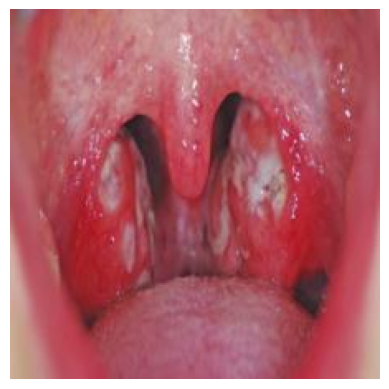

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/6.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/15.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/29.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/19.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/34.jpeg
Tonsillar Exudate: NAD  
Tonsillar Swelling: NAD  
Uvula Deviation: NAD  
Erythema: Present, with redness visible in the throat.  
Ulcers: NAD  
Special Notes: NAD  


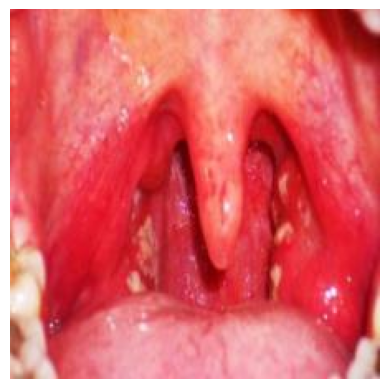

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/21.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/31.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/32.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/30.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/7.jpeg
Tonsillar Exudate: Present, with white patches visible on tonsils.  
Tonsillar Swelling: Present, tonsils appear enlarged.  
Uvula Deviation: NAD.  
Erythema: Present, noticeable redness in the throat.  
Ulcers: NAD.  
Special Notes: NAD.  


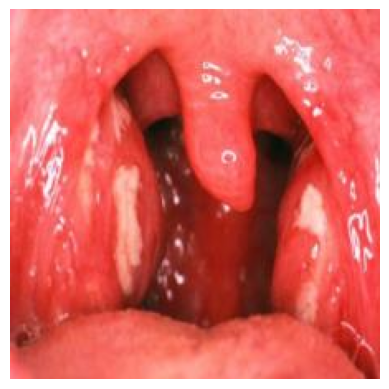

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/13.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/12.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/24.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/3.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/11.jpeg
Tonsillar Exudate: NAD  
Tonsillar Swelling: NAD  
Uvula Deviation: NAD  
Erythema: Present  
Ulcers: NAD  
Special Notes: NAD  


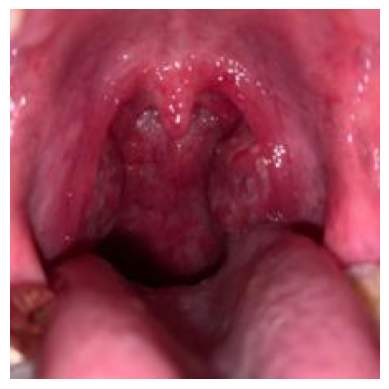

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/16.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/33.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/26.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/17.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/1.jpeg
Tonsillar Exudate: Present
Tonsillar Swelling: Present
Uvula Deviation: NAD
Erythema: Present
Ulcers: NAD
Special Notes: NAD


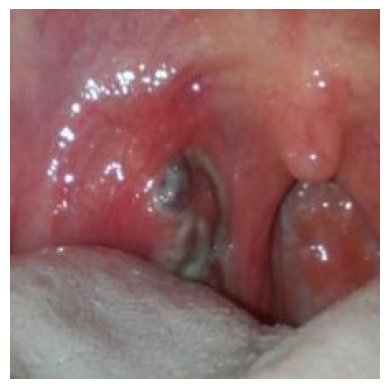

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/2.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/18.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/14.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/9.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/23.jpeg
Tonsillar Exudate: Present, white patches noted on tonsils.  
Tonsillar Swelling: Present, enlarged tonsils observed.  
Uvula Deviation: NAD.  
Erythema: Present, redness around the tonsils.  
Ulcers: NAD.  
Special Notes: NAD.


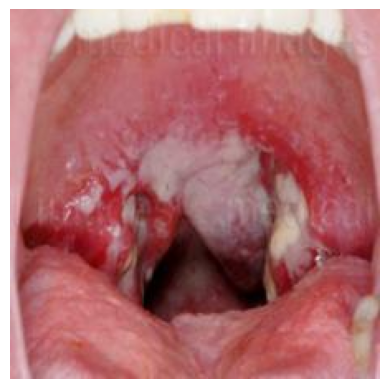

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/10.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/25.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/4.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/27.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/5.jpeg
Tonsillar Exudate: Present, with white patches noted on the tonsils.  
Tonsillar Swelling: Present, tonsils appear enlarged.  
Uvula Deviation: NAD.  
Erythema: Present, redness observed in the throat.  
Ulcers: NAD.  
Special Notes: Notable presence of white patches, possibly indicating some form of infection.


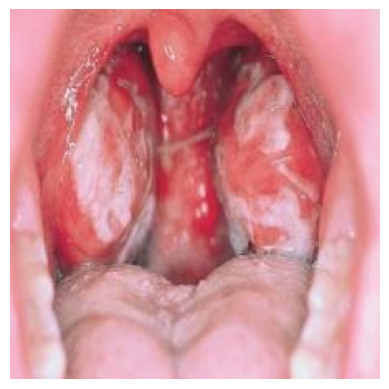

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/8.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/22.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class1/28.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/2.jpeg
Tonsillar Exudate: Present, appears as white patches on the tonsils.  
Tonsillar Swelling: Present, tonsils are enlarged.  
Uvula Deviation: NAD  
Erythema: Present, throat shows redness.  
Ulcers: NAD  
Special Notes: NAD  


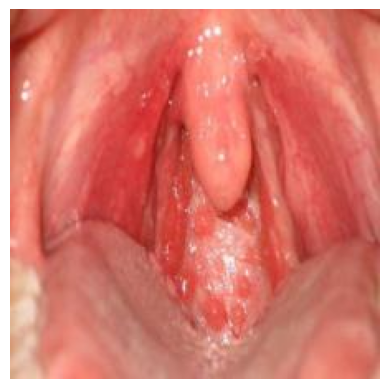

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/20.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/3.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/7.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/9.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/14.jpeg
Tonsillar Exudate: NAD  
Tonsillar Swelling: NAD  
Uvula Deviation: NAD  
Erythema: Present, mild redness noted in the oropharynx.  
Ulcers: NAD  
Special Notes: NAD  


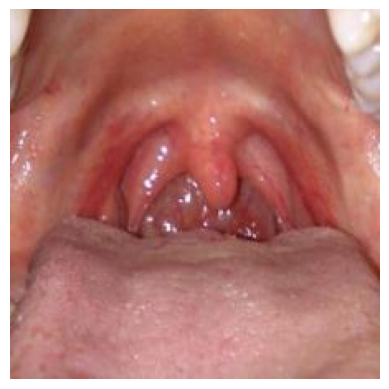

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/19.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/8.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/12.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/15.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/11.jpeg
Tonsillar Exudate: NAD  
Tonsillar Swelling: NAD  
Uvula Deviation: NAD  
Erythema: Present, redness observed  
Ulcers: NAD  
Special Notes: NAD  


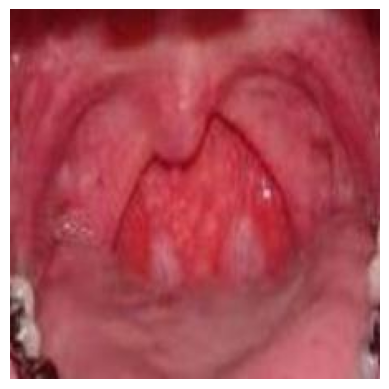

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/16.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/13.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/5.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/6.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/4.jpeg
Tonsillar Exudate: NAD  
Tonsillar Swelling: NAD  
Uvula Deviation: NAD  
Erythema: Present, mild redness observed  
Ulcers: NAD  
Special Notes: NAD  


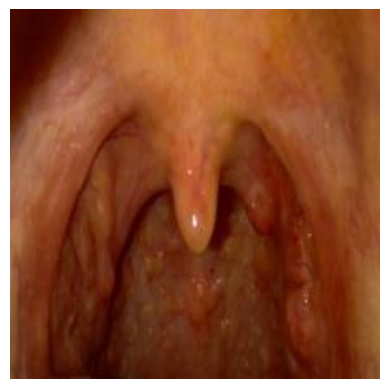

/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/21.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/18.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/1.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/10.jpeg
/content/drive/MyDrive/STREPDB/datasets/Original/Valfolder/Class0/17.jpeg
Tonsillar Exudate: NAD  
Tonsillar Swelling: NAD  
Uvula Deviation: NAD  
Erythema: Present, there is redness noted in the throat.  
Ulcers: NAD  
Special Notes: NAD  


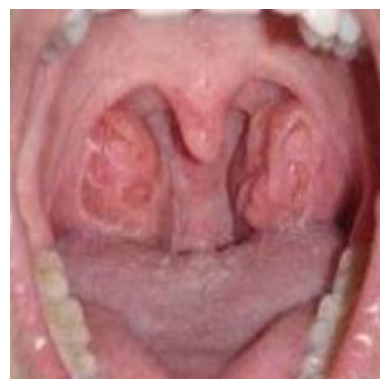

NameError: name 'data' is not defined

In [ ]:
# Generating text labels for each image in the validation set or training set.
image_folder = "/content/drive/MyDrive/STREPDB/datasets/Original"

label_data = {}

subfolder = "Valfolder/Class1"

for i, filename in enumerate(os.listdir(os.path.join(image_folder, subfolder))):
    verbose = False
    if(i%5 == 0): verbose = True
    entry = generate_entry(os.path.join(image_folder, subfolder, filename), verbose)
    label_data[os.path.join(subfolder, filename)] = entry

subfolder = "Valfolder/Class0"


for i, filename in enumerate(os.listdir(os.path.join(image_folder, subfolder))):
    verbose = False
    if(i%5 == 0): verbose = True
    entry = generate_entry(os.path.join(image_folder, subfolder, filename), verbose)
    label_data[os.path.join(subfolder, filename)] = entry


# skip = True
# subfolder = "Trainfolder/Class0"
# for i, filename in enumerate(os.listdir(os.path.join(image_folder, subfolder))):
#     if(filename == "103.jpeg"): skip = False
#     if(skip): continue
#     verbose = False
#     if(i%5 == 0): verbose = True
#     entry = generate_entry(os.path.join(image_folder, subfolder, filename), verbose)
#     label_data2.append(entry)


    # break

# File path where the JSON will be saved
json_file_path = 'gpt_val_signs.json'

# Writing the list to a JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"JSON file created successfully at {json_file_path}")

In [ ]:
json_file_path = 'gpt_val_signs.json'

# Writing the list to a JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(label_data, json_file, indent=4)

print(f"JSON file created successfully at {json_file_path}")

JSON file created successfully at gpt_val_signs.json
